Author: Landon Buechner

Date: December 20, 2020

- **Key references** that helped me contextualize this analysis. 
    - [The Emergence of Antibiotic Resistance by Mutation](https://www.sciencedirect.com/science/article/pii/S1198743X14615500)

    - [Hypermutation as a Factor Contributing
    to the Acquisition of Antimicrobial Resistance](https://pdfs.semanticscholar.org/4fc3/2983feab3022700c331070fcb7427b7a6274.pdf?_ga=2.11542449.449471926.1608450407-1106449957.1601076234)

- **Google's JAX framework ([GitHub](https://github.com/google/jax))** is what I used to construct and train my CNN. 


In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import partial
plt.rcParams.update({'font.size': 14})

from collections import Counter 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import DataLoader

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, MaxPool, Conv, Dense, Flatten, Relu, LogSoftmax, GeneralConv 
from jax.experimental import optimizers

# EDA

In [ ]:
raw_data = np.load("dataset.npy", allow_pickle=True).item()
data = pd.DataFrame(raw_data).sample(frac = .20).reset_index()

print(f'Numer of samples: {data.shape[0]}')
data.head()

Numer of samples: 20000


,index,resistant,genes
0,4891,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
1,76793,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,52054,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
3,64393,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
4,50767,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...


With respect to the available RAM in the free google colab environment, a 40% downsample is the maximum sample size that doesn't cause the session to crash. It turns out that I get the same level of accuracy with the tuned architecture even if I walk it down to 20%. The final performance results are discussed in the Model Selection subsection.

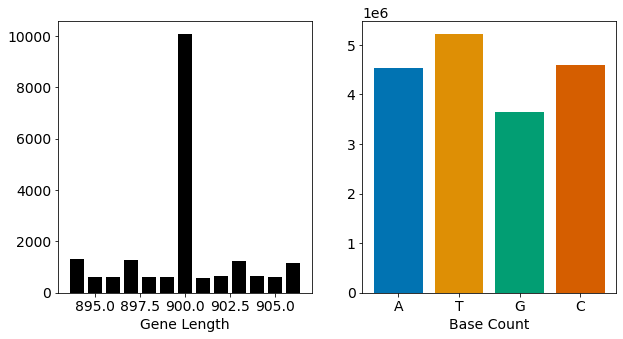

In [ ]:
seq_lengths = list(map(len, data['genes']))
seq_counts = Counter(seq_lengths) 
base_counts = Counter(base for seq in data['genes'] for base in seq)

clrs = sns.color_palette("colorblind", n_colors= 4)
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].bar(seq_counts.keys(), seq_counts.values(), color = 'k')
ax[0].set_xlabel('Gene Length')
ax[1].bar(base_counts.keys(), base_counts.values(), color = clrs)
ax[1].set_xlabel('Base Count')
plt.show()


As we can see, there is the initial issue of sequences with varying length. Naively we could trim each sequence to be the first 894 bases but this results in the loss of a significant amount of information. This entails that the input data is of dimension (906, 5).

Consider the amount of information lost if the sequences were truncated to have equal length.

In [ ]:
lost_data = sum([i for i in seq_lengths if i > 894])
print("Assuming no padding and sequences are truncated\n")
print(f"Total bases: {sum(seq_lengths)}")
print(f"Bases dropped: {lost_data}")
print(f"Percent of data lost: {round(100*(1-lost_data/sum(seq_lengths)),2)}%")

Assuming no padding and sequences are truncated

Total # bases: 17999363
# bases dropped: 16838057
Percent of data lost: 6.45%


It turns out that the model accuracy for the tuned architecture drops by about 1-2% whenever the sequences are not padded, i.e when the model is trained data of dimension (894, 4). 

# Data Processing

In [ ]:
def process_data(raw_data):
  """
  Resolves the issue of sequences with varying length. 
  """
  max_length = max(list(map(len, raw_data['genes'])))
  padded_seqs = [seq.ljust(max_length, 'X') for seq in raw_data['genes']]
  split_seqs = np.array([list(i) for i in padded_seqs])

  bases = list("ACGTX")
  encoding = OneHotEncoder()
  encoding.fit(np.array(bases).reshape(-1,1)) 
  encoded_seqs = encoding.transform(split_seqs.reshape(-1,1)).toarray()

  X_data = encoded_seqs.reshape(len(split_seqs), 1, max_length, 5)  
  y_data = np.array([1 if i == True else 0 for i in raw_data['resistant']])
  return X_data, y_data

@dataclass
class Dataset:
  """
  Necessary class for torch dataloaders
  """
  genes : np.array
  resistance : np.array
    
  def __len__(self):
    return len(self.resistance)

  def __getitem__(self, index):
    return self.genes[index], self.resistance[index]

In [ ]:
X, y = process_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

print(f'Shape of the encoded data: {X_train[0].shape}\n')
print(data.iloc[0]['genes'][:10], '....\n') # not the same sample
X_train[0]

Shape of the encoded data: (1, 906, 5)

ATGCACTACC ....



array([[[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]])

# Modelling Tools

In [ ]:
class CNN:
  """
  Used to initialize a CNN for a given input architecture.

  The make_model() method iterates through a list of dictionaries
  and sequenctially constructs layers within jax.stax.serial()

  Note that the add_layer() method has a limited selection of layer
  types at the moment. Other activation functions are not explored
  but could be easily added for later use of this collection of classes.
  This hold true for any layer types supported by jax.
  """
  def __init__(self, architecture : dict):
    self.init_fun, self.model = self.make_model(architecture)

  def make_model(self, architecture):
    return stax.serial(*list(map(self.add_layer, architecture)))

  def add_layer(self, L):
    if L['layer'] == 'conv':
      return Conv(L['c_out'], filter_shape = L['w_shape'], strides = L['stride'], padding="SAME")
    elif L['layer'] == 'maxpool':
      return MaxPool(window_shape = L['w_shape'], strides = L['stride'], padding="SAME")
    elif L['layer'] == 'batchnorm':
      return BatchNorm()
    elif L['layer'] == 'relu':
      return Relu
    elif L['layer'] == 'flatten':
      return Flatten
    elif L['layer'] == 'dense':
      return Dense(L['out_dim'])
    elif L['layer'] == 'logsoftmax':
      return LogSoftmax

In [ ]:
class Operations:
  """
  Miscellaneous methods for model training and validation.
  """
  # Constructs JAX device array for boolean comparison in accuracy calculation
  @staticmethod 
  def one_hot(y, num_classes):
    return jnp.array(y[:, None] == np.arange(num_classes), dtype = np.float32)

  @staticmethod
  def model_accuracy(model, params, data_loader):
    accuracy = 0
    for _, (X, y) in enumerate(data_loader):
      targets = Operations.one_hot(np.array(y), 2)
      pred_class = jnp.argmax(model(params, np.array(X)), axis = 1)
      target_class = jnp.argmax(targets, axis = 1)
      accuracy += np.sum(pred_class == target_class)
    return accuracy/len(data_loader.dataset)

  # Takes input X,y arrays and constructs dataloader
  @staticmethod
  def load(X, y, batch_size):
    return DataLoader(Dataset(X, y), batch_size = batch_size, shuffle=True)

In [ ]:
class TrainNetwork(Operations):
  """
  Optimizes paramaters for a given model architecture.
  Takes advantage of parallelism if connected to a 
  GPU/TPU enabled runtime.
  
  Note that the optimized model paramaters are updated 
  and stored in the internal cnn member. Post training, 
  they are accessed by calling TrainNetwork(...).cnn.params 

  Further improvements to this class would be adding additional 
  optimizer choices in the set_optimizer() method. The same could
  said for loss function options. Also, the current dimensions of 
  training data (1, 906, 5) are predefined. TrainNetwork is one step 
  away from being a multipurpose training class for any given neural 
  network model. 
  """
  def __init__(self, 
      cnn : CNN,
      train_loader : torch.utils.data.DataLoader, 
      test_loader : torch.utils.data.DataLoader,
      batch_size : int, 
      num_epochs : int, 
      step_size : float,
      view = True):
    
    self.cnn = cnn
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.batch_size = batch_size
    self.num_epochs = num_epochs
    self.view = view
    self.model_state = 'Untrained'
    self.key = random.PRNGKey(1)

    self.params = self.initialize_network()
    self.opt_init, self.opt_update, self.get_params = self.set_optimizer(step_size)

  def __repr__(self):
    if self.model_state == 'Untrained':
      return 'Untrained Network'
    elif self.model_state == 'Trained':
      return f'Trained Anitbiotic Resistance Classifier\n \
        Input Shape: {self.train_loader.dataset.genes[0].shape}'

  def initialize_network(self):
    _, params = self.cnn.init_fun(self.key, (self.batch_size, 1, 906, 5))
    return params

  def set_optimizer(self, step_size):
      return optimizers.adam(step_size)
       
  def cross_entropy(self, params, X, y):
    preds = self.cnn.model(params, X)
    return -jnp.sum(preds * y) 

  # Parallelized gradient computation and paramater update 
  @partial(jit, static_argnums=(0))
  def update(self, params, X, y, opt_state):
    values, grads = value_and_grad(self.cross_entropy)(params, X, y)
    opt_state = self.opt_update(0, grads, opt_state) 
    return self.get_params(opt_state), opt_state, values

  def train(self):
    """
    1. Iteratively updates the internal CNN class instance paramaters.
    2. Logs/prints training result data and returns a TrainResult object.
    3. Selects paramaters from epoch with the highest test accuracy. 
    """
    # Initializing parameters
    opt_state = self.opt_init(self.params)
    self.params = self.get_params(opt_state)

    # Training loop with necessary jax.np.array transformations
    model_params, TrainAccuracy, TestAccuracy, TrainLoss = [], [], [], []
    for epoch in range(self.num_epochs):
      t0 = time.time()
      for _, (X, y) in enumerate(self.train_loader):
        X = jnp.array(X)
        y = self.one_hot(jnp.array(y), 2) 
        self.params, opt_state, loss = self.update(self.params, X, y, opt_state)
        model_params.append(self.params)
        TrainLoss.append(loss)
      
      # Computing in/out-sample model accuracy
      train_acc = self.model_accuracy(self.cnn.model, self.params, self.train_loader)
      test_acc =  self.model_accuracy(self.cnn.model, self.params, self.test_loader)
      TrainAccuracy.append(train_acc)
      TestAccuracy.append(test_acc)

      # Toggle to display training epochs. Useful for inspecting train times.
      if self.view == True:
        print(f"Epoch {epoch+1} | Time {round(time.time()-t0, 2)} | Train {train_acc:.4f} | Test {test_acc:.4f}")

    # Selecting params with best test accuracy
    best_index = TestAccuracy.index(max(TestAccuracy))
    self.cnn.params = model_params[best_index]
    self.model_state = 'Trained'
    return TrainResults(TrainLoss, TrainAccuracy, TestAccuracy)

In [ ]:
@dataclass
class TrainResults:
  """
  Output of TrainNetwork and used within CrossValidation.

  Stores accuracy/loss infromation from each epoch and has the .accuracy
  property for easy access to the maximum accuracy score. 

  As it stands, the CrossValidation class only optimizes parameters 
  for a fixed CNN architecture. An improvement would be to have this
  class contain CNN meta-data so that a a collection ofcandidate 
  architectures can be optimzed at the model selection stage.
  """
  TrainLoss : list
  TrainAccuracy : list
  TestAccuracy : list

  def __post_init__(self):
    self.data = self.format_data()

  def format_data(self):
    return pd.DataFrame({
        'TrainAcc': self.TrainAccuracy,
        'TestAcc': self.TestAccuracy})
    
  @property
  def loss(self):
    return pd.Series(self.TrainLoss, name='TrainLoss')

  @property
  def accuracy(self):
    return self.data['TestAcc'].max()

In [ ]:
@dataclass
class CrossValidation(Operations):
  """
  K-Fold cross validation for model selection
  """
  input_cnn : CNN
  batch_size : int
  num_epochs : int
  step_size : float
  k_fold : int
  X_train : np.array
  X_test : np.array
  y_train : np.array
  y_test : np.array
    
  def __post_init__(self):
    assert self.k_fold > 1
    self.X_folds, self.y_folds = self.make_folds()
    self.test_loader = self.load(self.X_test, self.y_test, self.batch_size)

  # Splits the data into K subsets
  def make_folds(self):
    X_folds = np.split(self.X_train, self.k_fold)
    y_folds = np.split(self.y_train, self.k_fold)
    return X_folds, y_folds

  # Concatenates the k-1 remaining folds so that they can be fed into dataloader
  def get_folds(self, i):
    indicies = [j for j in range(self.k_fold) if j!=i]
    _X_train = np.concatenate([self.X_folds[j] for j in indicies])
    _y_train = np.concatenate([self.y_folds[j] for j in indicies])
    _X_test = self.X_folds[i]
    _y_test = self.y_folds[i]
    return _X_train, _y_train, _X_test, _y_test

  def run(self):
    model_params, performance = [], []
    for i in range(self.k_fold):
      print(f'\n---- Fold # {i+1} ----\n')
      # Formatting data
      _X_train, _y_train, _X_test, _y_test = self.get_folds(i)
      _train_loader = self.load(_X_train, _y_train, self.batch_size)
      _test_loader = self.load(_X_test, _y_test, self.batch_size)

      # Training CNN and logging params/performance
      cnn = TrainNetwork(self.input_cnn,  _train_loader, _test_loader, 
          self.batch_size, self.num_epochs, self.step_size)
      results = cnn.train()
      model_params.append(cnn.params)
      performance.append(results.data.iloc[-1])

    # Selecting the best model out of the k-folds
    perf_df = pd.DataFrame(performance).reset_index().drop(columns = ['index'])
    best_model_acc = perf_df.sort_values(by = ['TestAcc'], ascending = False).iloc[0,:]
    best_params =  model_params[best_model_acc.name]

    # Displaying relevant metrics
    in_sample_acc = best_model_acc['TestAcc']
    out_sample_acc = self.model_accuracy(self.input_cnn.model, best_params, self.test_loader)
    print('\n'+'-'*15)
    print(f'In-sample Accuracy: {in_sample_acc:.4f}')
    print(f'Test Accuracy: {out_sample_acc:.4f}')
    return best_params, perf_df

# Exploring Architectures

In the following section I exhaustively explore various architectures. Since my background is not in bioinformatics, I surveyed the following papers to get me pointed in the right direction. It was informative to read about the various encoding schemes and model architectures despite the respective modelling tasks of interest being different than the one pursued in this notebook.

1. [Convolutional neural networks for classification
of alignments of non-coding RNA sequences](https://academic.oup.com/bioinformatics/article/34/13/i237/5045743)

2. [Convolutional neural network architectures
for predicting DNA–protein binding](https://dspace.mit.edu/bitstream/handle/1721.1/111019/Convolutional%20neural%20network%20architectures%20for%20predicting%20DNA%E2%80%93protein%20binding.pdf?sequence=1&isAllowed=y)
3. [DeepMHC: Deep Convolutional Neural Networks for
High-performance peptide-MHC Binding Affinity Prediction](https://www.biorxiv.org/content/10.1101/239236v1.full.pdf)

In terms of convolutional neural networks themselves, this reference serves as a great resource for understanding the output dimensionalities of operations such as convolution, pooling, etc.

- [Convolutional Arithmetic](https://arxiv.org/pdf/1603.07285.pdf)

### Remarks

In terms of the constructed classes defined above, the training pipeline is as follows:

$ \text{Dataset} \rightarrow \text{Operations.load} \rightarrow\text{CNN} \rightarrow \text{CrossValidation}(\text{TrainNetwork}) $

There could have been an intermediate step where I programmatically optimized the model architecture; but as seen in the following cells, a first few ad-hoc guesses of simple architectures results in a model structure that performs very well. Quick prototyping is possible because the downsampled dataset is relatively small and the training is parallelized on the GPU.

### Going Forward
Below are variety of networks with tunable hyperparametres such as the number of kernels, window size, and stride. I do not experiment with other activation functions or optimizers. I selected $\text{ReLu}$ and $\text{ADAM}$ respectively. I also use $\text{SAME}$ padding.

For the $\text{MaxPool}$ layer, the model has coin flip accuracy when it's window width along the convolved sequence is extended beyond 1. This makes sense because we are already convolving across sparse vectors of the form [0,1,0,0,0]. Additionally, about $1\text{-}2\text{%}$ accuracy is lost on average when the MaxPool window height to less than 5. Lastly, only a single convolutional layer is needed to for high performance. A deeper network is inapropriate in light of Occam's Razor.


In [ ]:
batch_size = 100
num_epochs = 10
step_size = 1e-3

train_loader = Operations.load(X_train, y_train, batch_size)
test_loader =  Operations.load(X_test, y_test, batch_size)

For this initial step I fix the window size as $(6, 5)$ and stride as $(1,1)$ and vary the number of kernels learned. I choose $(6, 5)$ to start because this would cover two codons in the DNA sequence. The selected stride is the simplest choice and is sufficient for now.

In [ ]:
accuracy, kernels  = [], [1, 4, 8, 16, 32, 64, 128]

for k in kernels: 
  architecture = [{'layer': 'conv', 'c_out': k, 'w_shape': (6,5), 'stride': (1,1)},
                  {'layer': 'maxpool', 'w_shape': (1,5), 'stride': (1,1)},
                  {'layer': 'batchnorm'}, {'layer': 'relu'}, 
                  {'layer': 'flatten'},
                  {'layer': 'dense', 'out_dim': 2}, 
                  {'layer': 'logsoftmax'}]

  jax_model = CNN(architecture)
  cnn = TrainNetwork(jax_model, train_loader, test_loader, 
                    batch_size, num_epochs, step_size, view = False)
  results = cnn.train()
  accuracy.append(results.accuracy)

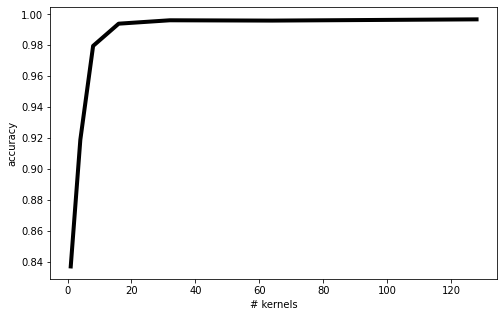

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(kernels, accuracy, color = 'k', linewidth = 4)
plt.xlabel('# kernels')
plt.ylabel('accuracy')
plt.show()

I proceed with 16 kernels/output channels because the accuracy can be seen to plateau. Interestingly, this is in line with the architecture perscribed by paper 2.

The models tested above are already extremely accurate. Nonetheless, I explore various window sizes. As previously mentioned, note that it doesn't make sense to stride along the encoding axis (dim = 5) because the data is one hot encoded. We are interested in learning patterns _spatially_ along the DNA sequence. Thus I set the window height to $(\cdot, 5)$.

In [ ]:
"""
The window widths are not equally spaced but are enough to 
probe the hyperparameter space.

Each of the 12 models trained/tested below are ran on the 
entire 25k downsample. 
"""
acc_samples = []
windows = [(1,5), (2,5), (4,5), (6,5), 
           (9,5), (12,5), (15,5), (18,5), 
           (24,5), (25,5), (27, 5), (30, 5), 
           (33, 5), (36, 5)]

for _ in range(4):
  # redefining the loaders so that the data gets shuffled
  train_loader = Operations.load(X_train, y_train, batch_size)
  test_loader = Operations.load(X_test, y_test, batch_size)

  accuracy = []
  for w in windows: 
    architecture = [{'layer': 'conv', 'c_out': 16, 'w_shape': w, 'stride': (1,1)},
                    {'layer': 'maxpool', 'w_shape': (1,5), 'stride': (1,1)},
                    {'layer': 'batchnorm'}, {'layer': 'relu'}, 
                    {'layer': 'flatten'},
                    {'layer': 'dense', 'out_dim': 2}, 
                    {'layer': 'logsoftmax'}]

    jax_model = CNN(architecture)
    cnn = TrainNetwork(jax_model, train_loader, test_loader, 
                       batch_size, num_epochs, step_size, view = False)
    results = cnn.train()
    accuracy.append(results.accuracy)
  acc_samples.append(accuracy)

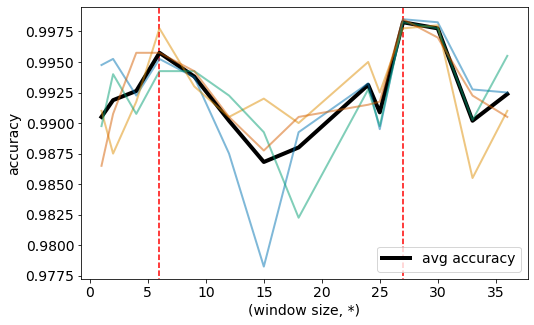

In [ ]:
mu_acc = np.mean(acc_samples, axis = 0)

plt.figure(figsize = (8, 5))
plt.plot([w[0] for w in windows], mu_acc, label = 'avg accuracy', color = 'k', linewidth = 4)
for i in range(4):
  plt.plot([w[0] for w in windows], acc_samples[i], color = clrs[i], linewidth = 2, alpha = .5)

for x in [6, 27]:
  plt.vlines(x = x, ymin = .90, ymax = 1, color = 'r', linestyle = 'dashed')
plt.ylim([np.min(acc_samples)-.001, np.max(acc_samples)+.001])
plt.xlabel('(window size, *)')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()

### Selected window size

The $(6,5)$ and $(27,5)$ windows have the highest accuracy. First note that these are both multiples of codon length 3. Suprisingly, the model favors a very wide window meaning that there is an underlying base/codon pattern that spans across relatively wide segments of the sequence. In terms antibiotic resistance profiles, there is an underlying codon permutation that spans up to 27 sequential bases! Naturally, mutations are the name of the game and are the true mechanism of interest.

While $(6,*)$ is a valid candidate parameter, it is of interest to note that the sampled accuracies converge for $(27,5)$ to a very small interval. Contrast this with the high variability of accuracy at any other given window width. Note that I have ran this on several shuffled training/test sets all which showed very similar results. 







### Underlying Biology

The paper below confirms the selected model architecture which is characterized by window width $3^3=27$. I tuned the model *before* learning that frameshift mutations are responsible for misreads that cause antibiotic resistance. It was very satisfying to come across this paper which validates the model architecture. 

[Antibiotic Resistance by High-Level Intrinsic Suppression of a Frameshift Mutation in an Essential Gene](https://www.pnas.org/content/117/6/3185)

  - **Frameshift Mutations ([Genome.gov](https://www.genome.gov/genetics-glossary/Frameshift-Mutation)):** A frameshift mutation is a type of mutation involving the insertion or deletion of a nucleotide in which the number of deleted base pairs is not divisible by three. "Divisible by three" is important because the cell reads a gene in groups of three bases. Each group of three bases corresponds to one of 20 different amino acids used to build a protein. If a mutation disrupts this reading frame, then the entire DNA sequence following the mutation will be read incorrectly. 

In [ ]:
acc_samples = []
strides = [(1,1), (2,1), (3,1), 
           (4,1), (5,1), (6,1), 
           (9,1), (12,1), (15,1)]

for _ in range(4):
  # redefining the loaders so that the data gets shuffled
  train_loader = Operations.load(X_train, y_train, batch_size)
  test_loader = Operations.load(X_test, y_test, batch_size)

  accuracy = []
  for s in strides:
    architecture = [{'layer': 'conv', 'c_out': 16, 'w_shape': (27,5), 'stride': s},
                    {'layer': 'maxpool', 'w_shape': (1,5), 'stride': (1,1)},
                    {'layer': 'batchnorm'},{'layer': 'relu'}, 
                    {'layer': 'flatten'},
                    {'layer': 'dense', 'out_dim': 2}, 
                    {'layer': 'logsoftmax'}]

    jax_model = CNN(architecture)
    cnn = TrainNetwork(jax_model, train_loader, test_loader, 
                       batch_size, num_epochs, step_size, view = False)
    results = cnn.train()
    accuracy.append(results.accuracy)
  acc_samples.append(accuracy)

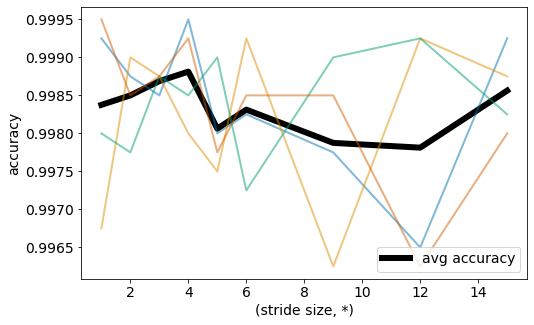

In [ ]:
mu_acc = np.mean(acc_samples, axis = 0)

plt.figure(figsize = (8, 5))
plt.plot([s[0] for s in strides], mu_acc, label = 'avg accuracy', color = 'k', linewidth = 6)
for i in range(4):
  plt.plot([s[0] for s in strides], acc_samples[i], color = clrs[i], linewidth = 2, alpha = .5)
plt.xlabel('(stride size, *)')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')
plt.show()

Unlike for window size, it looks like model accuracy is independent of the choice of stride. My basic understanding of genetics tells me that there is no underlying structure in the data that necessitates skipping across the sequence, especially considering that the chosen kernel size is already so spatially long. I proceed with stride $(1,1)$.

**Note:** I could be completely mistaken by trying to tune the model based on such a narrow accuracy range; though if I can get some additional juice out of the model, why not take it!

# Model Selection

In [ ]:
architecture = [{'layer': 'conv', 'c_out': 16, 'w_shape': (27,5), 'stride': (1,1)},
                {'layer': 'maxpool', 'w_shape': (1,5), 'stride': (1,1)},
                {'layer': 'batchnorm'},
                {'layer': 'relu'}, 
                {'layer': 'flatten'},
                {'layer': 'dense', 'out_dim': 2}, {'layer': 'logsoftmax'}]

optimal_model = CNN(architecture)

In [ ]:
k_fold = 5
CV = CrossValidation(optimal_model, batch_size, num_epochs, step_size, k_fold,
                     X_train, X_test, y_train, y_test)

optimal_params, cv_results = CV.run()


---- Fold # 1 ----

Epoch 1 | Time 3.32 | Train 0.7956 | Test 0.7869
Epoch 2 | Time 2.81 | Train 0.7977 | Test 0.7869
Epoch 3 | Time 2.86 | Train 0.9862 | Test 0.9847
Epoch 4 | Time 2.75 | Train 0.9055 | Test 0.8975
Epoch 5 | Time 2.87 | Train 0.9834 | Test 0.9819
Epoch 6 | Time 2.72 | Train 0.9852 | Test 0.9856
Epoch 7 | Time 2.81 | Train 0.9872 | Test 0.9862
Epoch 8 | Time 2.83 | Train 0.9964 | Test 0.9962
Epoch 9 | Time 2.83 | Train 0.9966 | Test 0.9966
Epoch 10 | Time 2.87 | Train 0.9973 | Test 0.9972

---- Fold # 2 ----

Epoch 1 | Time 3.46 | Train 0.7835 | Test 0.7919
Epoch 2 | Time 2.8 | Train 0.9541 | Test 0.9447
Epoch 3 | Time 2.82 | Train 0.8712 | Test 0.8637
Epoch 4 | Time 2.77 | Train 0.9816 | Test 0.9778
Epoch 5 | Time 2.82 | Train 0.9150 | Test 0.9094
Epoch 6 | Time 2.91 | Train 0.9904 | Test 0.9887
Epoch 7 | Time 2.72 | Train 0.9895 | Test 0.9891
Epoch 8 | Time 2.8 | Train 0.9966 | Test 0.9953
Epoch 9 | Time 2.8 | Train 0.9845 | Test 0.9837
Epoch 10 | Time 2.79 | Train 

Above I performed 5-fold crossvalidation on the 80% training set (16,000 observations) and report the best in-sample test accuracy out of the 5 folds. The test accuracy on the held out 20% is also reported. The model works great, $99.93\text{%}$ accuracy! 

# Model Interpretation

Now lets visualize some of the learned kernels. (I don't visualize the pooling layer)

In [ ]:
# converting the 16 kernels to a vanilla numpy array
# dropping the 'X' dummy base
kernels = np.array(np.mean(optimal_params[0][0][:,:4,:], axis = 2))

# params for colorbar
min_val, max_val = kernels.min(), kernels.max()

Learned feature maps



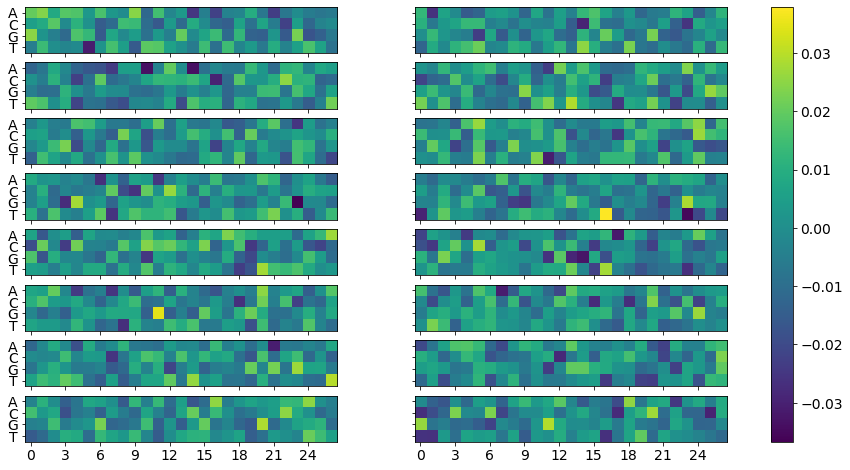

In [ ]:
print('Learned feature maps\n')

ticks = ['A', 'C', 'G', 'T', 'X']
fig, ax = plt.subplots(8, 2, figsize = (16,8), sharex = True, sharey = True)
iter = 0
for i in range(8):
  for j in range(2):
    im = ax[i,j].imshow(kernels[:,:,iter].T, vmin = min_val, vmax = max_val)
    ax[i,j].set_yticks(list(range(4)))
    ax[i,j].set_xticks(list(range(0,27,3)))
    ax[i,j].set_yticklabels(ticks)
    iter+=1
plt.colorbar(im, ax=ax.ravel().tolist())    
plt.show()

Based on the discussion above, these are to be interpreted as a collection of codon-sequence permutations which are related to the phenotypic expression of antibiotic resistance. Essentially, the kernels are 'filters' that enable optimal network activation when convolved with the DNA sequence. It can be argued that these mappings probe specific sequence configurations present throughout the training samples.




The focus for the remainer of this analysis is to identify what patterns the model is learning and how this relates to the underlying biology. Specifically, I try to identify:

1. Where mutations are occuring.
2. How the resistant and non-resistant samples differ.
3. What codon sequences are responsible for frameshift supression in the non-resistant samples.  

Consider the following operation

In [ ]:
# Note that the (27,5) kernels are sliced to be (4,4) for the sake of visualization
print('Slice of Model Paramaters\n')
a = kernels[:3,:4,0]
print(a,'\n')

print('Slice of the One Hot Encoded Sequence\n')
b = X_train[0][0][:27][:3,:4]
print(b,'\n')

# hadamard product 
print('Element wise product\n')
prod = a*b
print(prod,'\n')
print(f'Sum: {round(prod.sum(),4)}')

Slice of Model Paramaters

[[ 2.0340813e-02  5.2884254e-03  2.5084862e-02 -4.7984156e-03]
 [ 2.4067676e-02  8.8702431e-03  1.8136472e-03  1.4295945e-02]
 [ 8.7362425e-03  1.8465130e-02 -4.3651531e-03  4.2279436e-05]] 

Slice of the One Hot Encoded Sequence

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]] 

Element wise product

[[ 0.02034081  0.          0.         -0.        ]
 [ 0.          0.          0.          0.01429594]
 [ 0.          0.         -0.00436515  0.        ]] 

Sum: 0.0303


The kernels visualized above are slid across the entire sequence to generate a similarity measure as a function of sequence index. My hypothesis is that mutations occur at specific locations. To verify this hypothesis, I could sample segments of the same length randomly from the sequence and compare their respective prediction accuracies to the performance of the region of interest.

If in fact a handfull of regions are information dense compared to the rest of the sequence, then further analysis can be done to explore what kind of mutations are occuring. Ultimately, the underlying codon structure causing antibiotic resistance can be uncovered.


### Frameshift Mutations

I now discuss the patterns learned by the CNN and interpret them in the context of frameshift mutations, a primary factor of antibiotic resistance expressed in this particular dataset.

In [ ]:
class SeqAnalysis:
  """
  The smoothing paramater gives a better view of where
  a particular kernel motif apears in a sequence. This 
  averaging does not result in a large loss of information  
  because each stride of the kernel adds and subtracts one 
  weight from the left and right side respectively for each 
  step across the entire sequence.
  """
  def __init__(self, kernels, X_train, y_train, smoothing):
    self.kernels = kernels
    self.X_train = X_train
    self.y_train = y_train
    self.num_samples = len(y_train)
    self.smoo = smoothing

  def convolve(self, index, kerr):
    similarity = [(self.X_train[index][0][i:i+27][:,:4]*self.kernels[:,:4,kerr]).sum() for i in range(400)]
    smoothed = np.convolve(similarity, np.ones(self.smoo)/self.smoo, mode='same')
    return smoothed

  def get_type(self, index):
    if self.y_train[index] == 1:
      return 'resistant'
    elif self.y_train[index] == 0:
      return 'non-resistant'

  def plot_overlay(self, kerr, seqs):
    types = list(map(self.get_type, seqs))
    plt.figure(figsize = (8,4))
    for i in range(len(seqs)):
      vals = self.convolve(seqs[i], kerr)
      plt.plot(list(range(len(vals))), vals, linewidth = 2, label = types[i], alpha = .8)
    plt.xlabel('seq_index')
    plt.ylabel('Kernel Similarity')
    plt.legend(prop={'size': 10}, loc = 'upper right')
    plt.show()

In [ ]:
smoothing = 10
tool = SeqAnalysis(kernels, X_train, y_train, smoothing)

### Inspecting Kernel # 1

All 3 plots below are characterized by increased variability of the similarity metric in the 100-150 region. In otherwords, kernel #1 'activates' at this location. It is not suprising that it identifies the exact location of a frameshift considering the model has $99\text{%}+$ accuracy. 

To make what I am doing more clear see that for everywhere else in index range, the convolution of any two sequences considered are near identical *except* at the location of interest. The variability at the 'activation location' can be attributed to the kernel running into a sequence of codons that simultaneously activates a set parameters causing the two convolution sequences to diverge. 

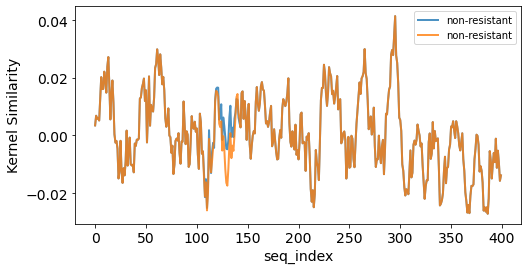

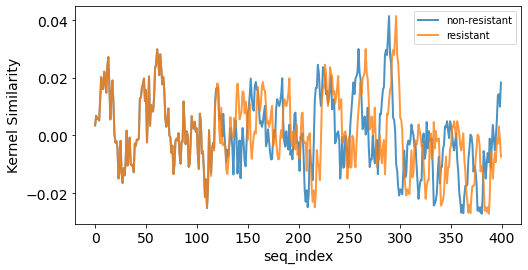

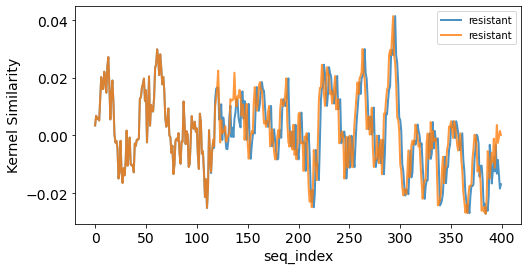

In [ ]:
kerr = 1
tool.plot_overlay(kerr, [17,18])
tool.plot_overlay(kerr, [0,1])
tool.plot_overlay(kerr, [5,8])

1. **Non-Resistant / Non-Resistant**: Frameshift suppression occurs and the sequences realign resulting in phenotypic expression of no resistance. 
    - **Frameshift Supression ([Oxford](https://www.oxfordreference.com/view/10.1093/oi/authority.20110803095832159)):** The process whereby the effects of a frameshift mutation are overcome, either by the reinsertion of the original gene or by the action of a specialized form of transfer RNA, called an extragenic frameshift suppressor, that can recognize four-base sequences.

2. **Non-Resistant / Resistant**: Again we see activation occur but the resistant sequence remains shifted.
    - Bacteria, in response to selective pressures created by antibiotic exposure, rapidly evolve resulting in subsequent generations that exhibit frameshift mutations. 

3. **Resistant / Resistant**: Post activation, both sequences are shifted by some integer number that is a function of insertion and deletion count. Note that if a third, non-resistant, figure were to be overlayed it would be more clear that there is in fact a shift here.

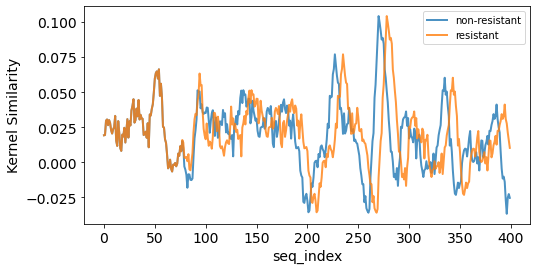

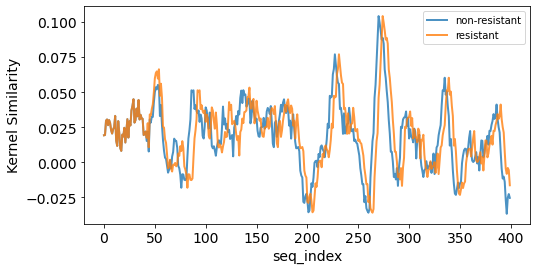

In [ ]:
kerr = 0
tool.plot_overlay(kerr, [3, 65])
tool.plot_overlay(kerr, [234, 8])

Here is another kernel and a few plots. Activation occurrs at around index 50. The same remarks from (2) above apply. See that the increase of similarity of each sequence with kernel #0 at index 50 marks the beggining of frameshift mutation! Thus, I have used the internal parameters of the trained CNN as an analysis tool to better understand the mutation behavior inheret in the provided training data.



# To-Do

1. Calculate model accuracy with every base zeroed out that does not lay in the mentioned region and compare model accuracy against the accuracy of randomly sampled segments of equal length. 
2. Aggregate collection of locations and typical codon motifs present in these regions for future consideration. Map to proteins. Cross reference the literature to see if the identified motifs are known to be associated with resistance profiles.